In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
import math
import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image

In [ ]:
# Формирование пробного изображения
# Случайный белый квадрат (1) на черном фоне (0)
N = 16
K = int(N/4)
def fn1(N, K):
    a = np.zeros((N,N))
    i0 = random.randint(0, N-K)
    j0 = random.randint(0, N-K)
    for i in range(K):
        for j in range(K):
            a[i0+i, j0+j] = 0.9
    return a

# преобразование Фурье прямое
def FT2Dc(im): 
    Nx, Ny = im.shape
    f1 = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            f1[i,j] = np.exp(1j * math.pi * (i + j))
    FT = np.fft.fft2(f1 * im)
    out = f1 * FT
    return out

# симуляция дифракционной картины
def diff1(img):
    img = (img - np.amin(np.amin(img)))/(np.amax(np.amax(img)) - np.amin(np.amin(img)))
    diff = np.absolute(FT2Dc(img))**2
    d_max = np.amax(np.amax(diff))
    return diff/d_max

In [ ]:
# Обучение нейросети для Прямого преобразования Фурье

# Размер матрицы
N = 16
# Размер батча
batch_size = 16

def theta(i, j, N):
    return 2 * np.pi * i * j / N

def RE(i, j, N):
    return np.cos(theta(i, j, N))

def IM(i, j, N):
    return - np.sin(theta(i, j, N))

# Определение фурье-сети
def ij(N, index):
    j = int(index % N)
    i = int((index - j) / N)
    return i, j

# Единичные матрицы
def fij(N, index):
    X = np.zeros((N, N))
    i, j = ij(N, index)
    X[i, j] = 1.0
    return X

# Фурье-образ единичной матрицы
def y_re(N, index):
    Y = np.zeros((N, N))
    i, j = ij(N, index)    
    for k in range(N):
        Y[i, k] = RE(k, j, N)
    return Y

def y_im(N, index):
    Y = np.zeros((N, N))
    i, j = ij(N, index)
    for k in range(N):
        Y[i, k] = IM(k, j, N)
    return Y

# Датасет для обучения RE
class Base_RE(Dataset):
    def __init__(self, N):
        self.N = N
        self.len = N * N        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        img1 = fij(self.N, index)
        img2 = y_re(self.N, index)
        img1 = torch.from_numpy(img1.reshape(self.N * self.N)).type(dtype=torch.float)
        img2 = torch.from_numpy(img2.reshape(self.N * self.N)).type(dtype=torch.float)
        return img1, img2
    
# Датасет для обучения IM
class Base_IM(Dataset):
    def __init__(self, N):
        self.N = N
        self.len = N * N        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        img1 = fij(self.N, index)
        img2 = y_im(self.N, index)
        img1 = torch.from_numpy(img1.reshape(self.N * self.N)).type(dtype=torch.float)
        img2 = torch.from_numpy(img2.reshape(self.N * self.N)).type(dtype=torch.float)
        return img1, img2
    
train_dataset_re = Base_RE(N)
train_loader_re = DataLoader(train_dataset_re, batch_size=batch_size, shuffle=True)    
train_dataset_im = Base_IM(N)
train_loader_im = DataLoader(train_dataset_im, batch_size=batch_size, shuffle=True)    

# Сеть 
class Net_FT(nn.Module):
    def __init__(self, N):
        super(Net_FT, self).__init__()
        self.fc = nn.Linear(N*N, N*N, bias=False)
    
    def forward(self, x):
        x = self.fc(x) 
        return x
    
    def loss_function(self, y_hat, y):
        return F.mse_loss(y_hat, y, reduction='sum')
    
def train(epoch, model, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (images, inputs) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = model.loss_function(outputs, inputs)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    a = train_loss / len(train_loader.dataset)
    return a
  

In [ ]:
model_re = Net_FT(N)
optimizer = optim.Adam(model_re.parameters(), lr=1e-4)
yy = []
for epoch in range(1, 3000):
    y = train(epoch, model_re, train_loader_re)
    yy += [y]

====> Epoch: 1 Average loss: 9.3585
====> Epoch: 2 Average loss: 9.3442
====> Epoch: 3 Average loss: 9.3306
====> Epoch: 4 Average loss: 9.3169
====> Epoch: 5 Average loss: 9.3032
====> Epoch: 6 Average loss: 9.2894
====> Epoch: 7 Average loss: 9.2758
====> Epoch: 8 Average loss: 9.2622
====> Epoch: 9 Average loss: 9.2487
====> Epoch: 10 Average loss: 9.2353
====> Epoch: 11 Average loss: 9.2219
====> Epoch: 12 Average loss: 9.2088
====> Epoch: 13 Average loss: 9.1956
====> Epoch: 14 Average loss: 9.1825
====> Epoch: 15 Average loss: 9.1695
====> Epoch: 16 Average loss: 9.1567
====> Epoch: 17 Average loss: 9.1438
====> Epoch: 18 Average loss: 9.1311
====> Epoch: 19 Average loss: 9.1184
====> Epoch: 20 Average loss: 9.1058
====> Epoch: 21 Average loss: 9.0933
====> Epoch: 22 Average loss: 9.0810
====> Epoch: 23 Average loss: 9.0685
====> Epoch: 24 Average loss: 9.0563
====> Epoch: 25 Average loss: 9.0441
====> Epoch: 26 Average loss: 9.0321
====> Epoch: 27 Average loss: 9.0200
====> Epoc

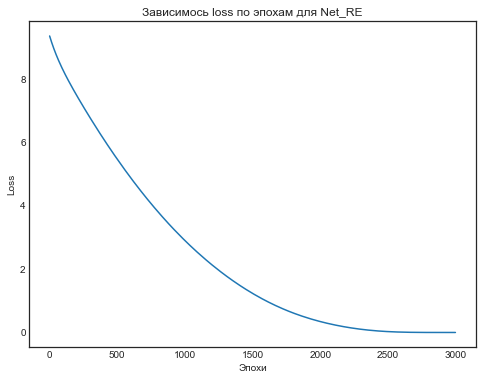

In [ ]:
plt.plot(yy);
plt.title('Зависимось loss по эпохам для Net_RE')
plt.xlabel('Эпохи');
plt.ylabel('Loss');

In [ ]:
re1 = list(model.fc.parameters())[0].data
re1

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ..., -8.1696e-42,
         -1.4257e-41,  4.3828e-08],
        [ 9.9985e-01,  9.2388e-01,  7.0711e-01,  ...,  6.3801e-42,
         -1.5511e-41, -1.0651e-41],
        [ 1.0000e+00,  7.0711e-01,  6.1232e-17,  ..., -1.6631e-41,
         -3.8564e-42, -3.2188e-42],
        ...,
        [-6.3479e-42,  8.6175e-10,  1.3014e-41,  ..., -9.2388e-01,
         -7.0711e-01,  3.8268e-01],
        [ 1.5968e-41,  8.7231e-42,  5.5385e-24,  ..., -7.0711e-01,
          8.3295e-15,  7.0711e-01],
        [-1.3604e-41, -9.6325e-42, -5.7229e-42,  ...,  3.8268e-01,
          7.0711e-01,  9.2388e-01]])

In [ ]:
model_im = Net_FT(N)
optimizer = optim.Adam(model_im.parameters(), lr=1e-4)
yy = []
for epoch in range(1, 3000):
    y = train(epoch, model_im, train_loader_im)
    yy += [y]

====> Epoch: 1 Average loss: 7.2973
====> Epoch: 2 Average loss: 7.2846
====> Epoch: 3 Average loss: 7.2726
====> Epoch: 4 Average loss: 7.2602
====> Epoch: 5 Average loss: 7.2481
====> Epoch: 6 Average loss: 7.2359
====> Epoch: 7 Average loss: 7.2239
====> Epoch: 8 Average loss: 7.2119
====> Epoch: 9 Average loss: 7.1999
====> Epoch: 10 Average loss: 7.1881
====> Epoch: 11 Average loss: 7.1763
====> Epoch: 12 Average loss: 7.1646
====> Epoch: 13 Average loss: 7.1531
====> Epoch: 14 Average loss: 7.1414
====> Epoch: 15 Average loss: 7.1302
====> Epoch: 16 Average loss: 7.1188
====> Epoch: 17 Average loss: 7.1076
====> Epoch: 18 Average loss: 7.0964
====> Epoch: 19 Average loss: 7.0854
====> Epoch: 20 Average loss: 7.0744
====> Epoch: 21 Average loss: 7.0634
====> Epoch: 22 Average loss: 7.0526
====> Epoch: 23 Average loss: 7.0418
====> Epoch: 24 Average loss: 7.0312
====> Epoch: 25 Average loss: 7.0206
====> Epoch: 26 Average loss: 7.0100
====> Epoch: 27 Average loss: 6.9995
====> Epoc

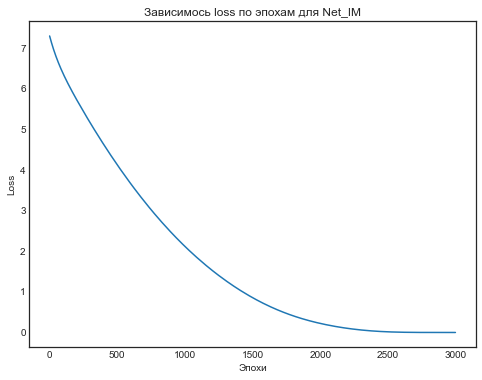

In [ ]:
plt.plot(yy);
plt.title('Зависимось loss по эпохам для Net_IM')
plt.xlabel('Эпохи');
plt.ylabel('Loss');

In [ ]:
im1 = list(model_im.fc.parameters())[0].data
im1

tensor([[ 4.2084e-07,  1.2822e-42,  8.1415e-42,  ..., -1.6479e-41,
         -8.0407e-42, -8.5059e-42],
        [-1.4352e-41, -3.8268e-01, -7.0711e-01,  ...,  1.1551e-41,
          1.1201e-41, -6.6302e-09],
        [-1.5497e-41, -7.0711e-01, -1.0000e+00,  ...,  4.2543e-42,
         -1.2928e-41,  8.7315e-42],
        ...,
        [ 1.6598e-41,  1.0378e-41, -8.8520e-42,  ...,  3.8268e-01,
         -7.0711e-01, -9.2388e-01],
        [ 1.6100e-41, -1.4027e-42, -2.3752e-42,  ..., -7.0711e-01,
         -9.9973e-01, -7.0711e-01],
        [ 1.3895e-41,  7.3806e-42,  1.6219e-41,  ..., -9.2388e-01,
         -7.0711e-01, -3.8268e-01]])

In [ ]:
# Демонстрация работы нейросетевых слоев фурье
it = iter(train_loader_re)

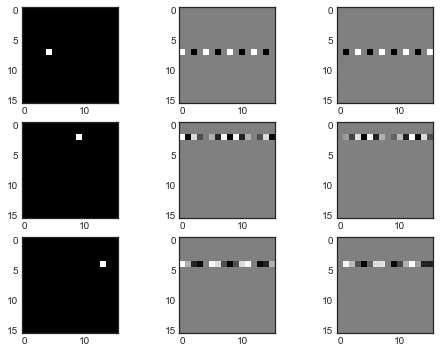

In [ ]:
images, inputs = next(it)
outputs = model(images)
plot9(images, inputs, outputs, 11,12,13)

In [ ]:
# Функции печати изображений

def plot3(images, inputs, outputs, n):
    i1 = images[n].numpy().reshape(N,N)
    i2 = inputs[n].numpy().reshape(N,N)
    i3 = outputs[n].detach().numpy().reshape(N,N)
    plt.subplot(1, 3, 1)
    plt.imshow(i1, cmap='gray');    
    plt.subplot(1, 3, 2)
    plt.imshow(i2, cmap='gray');    
    plt.subplot(1, 3, 3)
    plt.imshow(i3, cmap='gray');
    
def plot9(images, inputs, outputs, n1, n2, n3):
    i1 = images[n1].numpy().reshape(N,N)
    i2 = inputs[n1].numpy().reshape(N,N)
    i3 = outputs[n1].detach().numpy().reshape(N,N)
    i4 = images[n2].numpy().reshape(N,N)
    i5 = inputs[n2].numpy().reshape(N,N)
    i6 = outputs[n2].detach().numpy().reshape(N,N)
    i7 = images[n3].numpy().reshape(N,N)
    i8 = inputs[n3].numpy().reshape(N,N)
    i9 = outputs[n3].detach().numpy().reshape(N,N)
    plt.subplot(3, 3, 1)
    plt.imshow(i1, cmap='gray');    
    plt.subplot(3, 3, 2)
    plt.imshow(i2, cmap='gray');    
    plt.subplot(3, 3, 3)
    plt.imshow(i3, cmap='gray');
    plt.subplot(3, 3, 4)
    plt.imshow(i4, cmap='gray');    
    plt.subplot(3, 3, 5)
    plt.imshow(i5, cmap='gray');    
    plt.subplot(3, 3, 6)
    plt.imshow(i6, cmap='gray');
    plt.subplot(3, 3, 7)
    plt.imshow(i7, cmap='gray');    
    plt.subplot(3, 3, 8)
    plt.imshow(i8, cmap='gray');    
    plt.subplot(3, 3, 9)
    plt.imshow(i9, cmap='gray');
    
def plot9h(images, inputs, outputs, hidden, n1, n2, n3, NH):
    i1 = images[n1].numpy().reshape(N,N)
    i2 = hidden[n1].detach().numpy().reshape(NH,NH)
    i3 = outputs[n1].detach().numpy().reshape(N,N)
    i4 = images[n2].numpy().reshape(N,N)
    i5 = hidden[n2].detach().numpy().reshape(NH,NH)
    i6 = outputs[n2].detach().numpy().reshape(N,N)
    i7 = images[n3].numpy().reshape(N,N)
    i8 = hidden[n3].detach().numpy().reshape(NH,NH)
    i9 = outputs[n3].detach().numpy().reshape(N,N)
    plt.subplot(3, 3, 1)
    plt.imshow(i1, cmap='gray');    
    plt.subplot(3, 3, 2)
    plt.imshow(i2, cmap='gray');    
    plt.subplot(3, 3, 3)
    plt.imshow(i3, cmap='gray');
    plt.subplot(3, 3, 4)
    plt.imshow(i4, cmap='gray');    
    plt.subplot(3, 3, 5)
    plt.imshow(i5, cmap='gray');    
    plt.subplot(3, 3, 6)
    plt.imshow(i6, cmap='gray');
    plt.subplot(3, 3, 7)
    plt.imshow(i7, cmap='gray');    
    plt.subplot(3, 3, 8)
    plt.imshow(i8, cmap='gray');    
    plt.subplot(3, 3, 9)
    plt.imshow(i9, cmap='gray');    

In [ ]:
it = iter(train_loader)
images, inputs = next(it)
outputs, hidden = model(inputs)
plot9(images, inputs, outputs, 1,2,3)

In [ ]:
# Неудачные попытки аппроксимации GS глубокими полносвязаными сетями

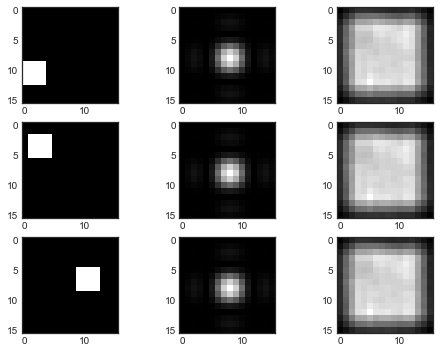

In [ ]:
plot9(images, inputs, outputs, 1,2,3)

In [ ]:
# Использование автоэнкодера и скрытого слоя 2х2 для восстановления 
# пробных изображений

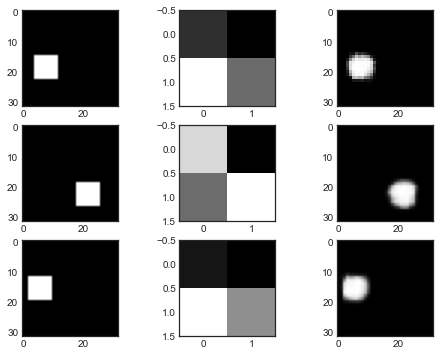

In [ ]:
plot9h(images, inputs, outputs, hidden, 1,2,3, 2)

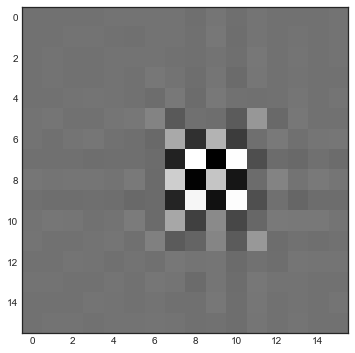

In [ ]:
# Перенос на PyTorch GS-алгоритма
# input: N, diff - tensor(N,N)
# output: recon_image - tensor(N,N)

###############################################

# Вспомогательные и служебные функции
PI = 3.1415927410125732

# симуляция дифракционной картины 
def np_diff(img):
    img = (img - np.amin(np.amin(img)))/(np.amax(np.amax(img)) - np.amin(np.amin(img)))
    diff = np.absolute(FT2Dc(img))**2
    #diff = np.log(diff + 100)
    d_max = np.amax(np.amax(diff))
    return diff/d_max    

def pt_f0(Z):
    f0 = torch.zeros((N, N))
    for i in range(N):
        for j in range(N):
            f0[i, j] = torch.tensor(Z * 1j * PI * (i + j))
    f1 = torch.exp(f0)
    return f1

F1 = pt_f0(1) 
F2 = pt_f0(-1) 

def pt_support(N):
    support = torch.zeros((N,N))
    R = int(N/4)
    for m in range(N):
        for n in range(N):
            x = N/2 - m
            y = N/2 - n
            if ((abs(x) < R) and (abs(y) < R)):
                support[m, n] = 1
    return support
           
SUPPORT = pt_support(N)    

def pt_treshold(x, N, treshold):
    support = SUPPORT
    for i in range(N):
        for j in range(N):
            if x[i, j] < 0 or support[i, j] < 0.5:
                x[i, j] = 0
            if x[i,j] > treshold:
                x[i,j] = treshold
    return x

###############################################

# преобразование Фурье
def pt_FT2Dc(im): 
    f1 = F1
    FT = torch.fft.fft2(f1 * im)
    out = f1 * FT
    return out

# обратное преобразование Фурье
def pt_IFT2Dc(im): 
    f1 = F2
    FT = torch.fft.ifft2(f1 * im);
    out = f1 * FT
    return out

def GS(diff):
    # Параметры
    NI = 200    
    treshold = 1
    # Только квадратные изображения
    N = diff.shape[0]
    
    dp_amplitude_exp = torch.sqrt(diff) 
    phase = (2 * torch.rand(N, N) - 1) * PI
    exp = torch.exp(1j * phase)
    field_detector_0 = dp_amplitude_exp * exp
    object_0 = pt_IFT2Dc(field_detector_0)
    gk = torch.real(object_0)
    
    for i in range(NI):
        field_detector = pt_FT2Dc(gk)
        phase = torch.angle(field_detector)
        exp = torch.exp(1j * phase)
        field_detector_updated = dp_amplitude_exp * exp
        gk_prime = torch.real(pt_IFT2Dc(field_detector_updated))
        gk = pt_treshold(gk_prime, N, treshold)
        
    phase = torch.angle(field_detector_updated)
    exp = torch.exp(1j * phase)
    field_detector = torch.sqrt(diff) * exp
    object1 = torch.real(pt_IFT2Dc(field_detector))
    return object1

def plot1(pt_image):
    i1 = pt_image.detach().real.numpy().reshape(N,N)
    plt.imshow(i1, cmap='gray');
def plot2(pt_image):
    i1 = pt_image.detach().numpy().reshape(N,N)
    plt.imshow(i1, cmap='gray');
    
recon = GS(bt)    
plot2(recon)

In [ ]:
# Нейросеть - аппроксиматор GS-алгоритма

In [ ]:
class Net_GS(nn.Module):
    def __init__(self, N, Grad):
        super(Net_GS, self).__init__()
        self.NI = 30    
        self.treshold = 1
        self.N = N
        self.PI = 3.1415927410125732
        self.M1 = self.M_fft()
        self.M2 = self.M_ifft()
        
        self.fft = nn.Linear(self.N * self.N, self.N * self.N, bias=False)
        self.ifft = nn.Linear(self.N * self.N, self.N * self.N, bias=False)
        self.fft.weight.data = self.M_fft()
        self.fft.weight.requires_grad = Grad
        self.ifft.weight.data = self.M_ifft()
        self.ifft.weight.requires_grad = Grad
    
    def forward(self, x):
        x = self.GS(x) 
        return x
    
    def GS(self, x):
        dp_amplitude_exp = torch.sqrt(x) 
        phase = (2 * torch.rand(self.N, self.N) - 1) * self.PI
        exp = torch.exp(1j * phase)
        field_detector_0 = dp_amplitude_exp * exp
        #i
        object0 = self.IFT2Dc(field_detector_0)
        gk = torch.real(object0)
    
        for i in range(self.NI):
            #d
            field_detector = self.FT2Dc(gk)
            phase = torch.angle(field_detector)
            exp = torch.exp(1j * phase)
            field_detector_updated = dp_amplitude_exp * exp
            #i
            object1 = self.IFT2Dc(field_detector_updated)
            gk_prime = torch.real(object1)
            gk = pt_treshold(gk_prime, self.N, self.treshold)
        
        phase = torch.angle(field_detector_updated)
        exp = torch.exp(1j * phase)
        field_detector = torch.sqrt(x) * exp
        #i
        object1 = self.IFT2Dc(field_detector)
        object1 = torch.real(object1)
        return object1
    
    # преобразование Фурье
    def _FT2Dc(self, x):     
        x = torch.fft.fft2(F1 * x)    
        return F1 * x
    
    # преобразование Фурье нейросетевое
    def FT2Dc(self, x): 
        x = self.M_fft2(F1 * x)
        return F1 * x
    
    # обратное преобразование Фурье
    def _IFT2Dc(self, x): 
        x = torch.fft.ifft2(F2 * x);
        return F2 * x
    
    # обратное преобразование Фурье нейросетевое
    def IFT2Dc(self, x): 
        x = self.M_ifft2(F2 * x)
        return F2 * x
    
    def M_fft(self):
        n = torch.arange(self.N)
        k = torch.reshape(n, (self.N, 1))
        return torch.exp(-2j * np.pi * k * n / self.N)

    def M_ifft(self):
        n = torch.arange(self.N)
        k = torch.reshape(n, (self.N, 1))
        return torch.exp(2j * np.pi * k * n / self.N) / self.N
    
    def M_fft2(self, x):
        x = x.type(dtype=torch.cfloat)        
        x = self.dot1(x)
        x = torch.transpose(x, 0, 1)
        x = self.dot1(x)
        x = torch.transpose(x, 0, 1)
        return x
    
    def _dot1(self, x):
        return torch.matmul(self.M1, x)
    
    def dot1(self, x):
        x = self.fft(x)
        return x

    def _dot2(self, x):
        return torch.matmul(self.M2, x)
    
    def dot2(self, x):
        x = self.ifft(x)
        return x

    def M_ifft2(self, x):
        x = x.type(dtype=torch.cfloat)        
        x = self.dot2(x)
        x = torch.transpose(x, 0, 1)
        x = self.dot2(x)        
        x = torch.transpose(x, 0, 1)
        return x

    def loss_function(self, y_hat, y):
        return F.mse_loss(y_hat, y, reduction='sum')
    
test_model = Net_GS(N, False)
print(test_model)
    
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (images, inputs) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = model.loss_function(outputs, inputs)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            pass
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(inputs)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    epoch_loss = train_loss / len(train_loader.dataset)
    return epoch_loss


Net_GS(
  (fft): Linear(in_features=256, out_features=256, bias=False)
  (ifft): Linear(in_features=256, out_features=256, bias=False)
)


In [ ]:
model_GS = Net_GS(N, False)
model_GS

Net_GS(
  (fft): Linear(in_features=256, out_features=256, bias=False)
  (ifft): Linear(in_features=256, out_features=256, bias=False)
)

In [ ]:
optimizer = optim.Adam(model_GS.parameters(), lr=1e-4)
for epoch in range(1, 10):
    train(epoch)

Train Epoch: 1 [0/256 (0%)]	Loss: 0.000000
====> Epoch: 1 Average loss: 0.0000
Train Epoch: 2 [0/256 (0%)]	Loss: 0.000001
====> Epoch: 2 Average loss: 0.0000
Train Epoch: 3 [0/256 (0%)]	Loss: 0.000001
====> Epoch: 3 Average loss: 0.0000
Train Epoch: 4 [0/256 (0%)]	Loss: 0.000001
====> Epoch: 4 Average loss: 0.0000
Train Epoch: 5 [0/256 (0%)]	Loss: 0.000001
====> Epoch: 5 Average loss: 0.0000
Train Epoch: 6 [0/256 (0%)]	Loss: 0.000000
====> Epoch: 6 Average loss: 0.0000
Train Epoch: 7 [0/256 (0%)]	Loss: 0.000000
====> Epoch: 7 Average loss: 0.0000
Train Epoch: 8 [0/256 (0%)]	Loss: 0.000000
====> Epoch: 8 Average loss: 0.0000
Train Epoch: 9 [0/256 (0%)]	Loss: 0.000000
====> Epoch: 9 Average loss: 0.0000


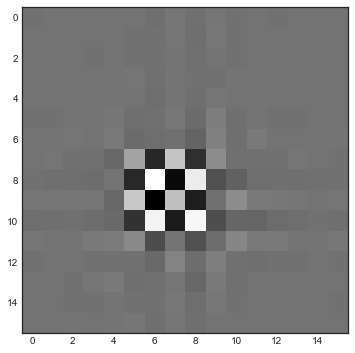

In [ ]:
model_gs = Net_GS(N, False)
recon = model_gs(bt)    
plot2(recon)

In [ ]:
model_GS = Net_GS(N, False)
print(model_GS.fft.weight.data.shape)
print(model_GS.fft.weight.requires_grad)
model_GS.fft.weight.data

torch.Size([16, 16])
False


tensor([[ 1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          1.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j],
        [ 1.0000e+00+0.0000e+00j,  9.2388e-01-3.8268e-01j,
          7.0711e-01-7.0711e-01j,  3.8268e-01-9.2388e-01j,
         -4.3711e-08-1.0000e+00j, -3.8268e-01-9.2388e-01j,
         -7.0711e-01-7.0711e-01j, -9.2388e-01-3.8268e-01j,
         -1.0000e+00+8.7423e-08j, -9.2388e-01+3.8268e-01j,
         -7.0711e-01+7.0711e-01j, -3.8268e-01+9.2388e-01j,
          1.1925e-08+1.0000e+00j,  3.8268e-01+9.2388e-01j,
          7.0711e-01+7.0711e-01j,  9.2388e-01+3.8268e-01j],
        [ 1.0000e+00+0.0000e+00j,  7.0711e-01-7.0711e-

In [ ]:
# FFT

r0 = np.array([0, 1, 2, 3, 4])
r1 = np.fft.fft(r0)
print(r1)
r2 = np.fft.ifft(r1)
print(r2)
print(np.allclose(r0, r2))

# FFT на numpy

def M_fft(N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    return np.exp(-2j * np.pi * k * n / N)

def M_ifft(N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    return np.exp(2j * np.pi * k * n / N) / N

M1 = M_fft(5)
r0 = np.array([0, 1, 2, 3, 4])
print(np.allclose(np.dot(M1, r0), np.fft.fft(r0)))

r1 = np.fft.fft(r0)
M2 = M_ifft(5)
r0_ = np.dot(M2, r1)
print(np.allclose(r0_, r0))

def M_fft2(N, x):
    M1 = M_fft(N)
    x = np.dot(M1, x)
    x = np.transpose(x)
    x = np.dot(M1, x)
    x = np.transpose(x)
    return x

def M_ifft2(N, x):
    M1 = M_ifft(N)
    x = np.dot(M1, x)
    x = np.transpose(x)
    x = np.dot(M1, x)
    x = np.transpose(x)
    return x

t0 = np.array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

t1 = M_fft2(5, t0)
print(np.allclose(t1, np.fft.fft2(t0)))
t0_ = M_ifft2(5, t1)
print(np.allclose(t0_, t0))   

True
True
True
True


In [ ]:
# FFT на PT

######### 1

def M_fft(N):
    n = torch.arange(N)
    k = torch.reshape(n, (N, 1))
    return torch.exp(-2j * np.pi * k * n / N)

def M_ifft(N):
    n = torch.arange(N)
    k = torch.reshape(n, (N, 1))
    return torch.exp(2j * np.pi * k * n / N) / N

M1 = M_fft(5)
r0 = torch.tensor([0, 1, 2, 3, 4], dtype=torch.cfloat)
r1 = torch.fft.fft(r0)
r1_ = torch.mv(M1, r0)
print(torch.allclose(r1_, r1))


M2 = M_ifft(5)
r0_ = torch.mv(M2, r1)
print(torch.allclose(r0_, r0))

######### 2

def M_fft2(N, x):
    M = M_fft(N)
    x = torch.matmul(M, x)
    x = torch.transpose(x, 0, 1)
    x = torch.matmul(M, x)
    x = torch.transpose(x, 0, 1)
    return x

def M_ifft2(N, x):
    M = M_ifft(N)
    x = torch.matmul(M, x)
    x = torch.transpose(x, 0, 1)
    x = torch.matmul(M, x)
    x = torch.transpose(x, 0, 1)
    return x

t0 = torch.tensor([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]], dtype=torch.cfloat)

t1 = torch.fft.fft2(t0)
t1_ = M_fft2(5, t0)
print(torch.allclose(t1_, t1, atol=1e-05))

t0_ = M_ifft2(5, t1)
print(torch.allclose(t0_, t0, atol=1e-05))

True
True
True
True
